In [1]:
from itertools import islice

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [3]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from pytorch_lightning.loggers import CSVLogger
from datasets import load_dataset

from estimator import LagGPTEstimator

[2023-08-14 10:27:34,471] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [4]:
dataset = get_dataset("electricity")

In [5]:
estimator = LagGPTEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    max_context_length=dataset.metadata.prediction_length*2 + dataset.metadata.prediction_length,
    
    scaling="std",
    # rope_scaling=dict(type="NoPe", factor=2.0),
    # nhead=2,
    n_layer=1,
    # num_decoder_layers=2,
    # dim_feedforward=16,
    # activation="gelu",
    
    batch_size=256,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(accelerator="gpu", precision="bf16-mixed", max_epochs=30),
    
)

In [6]:
predictor = estimator.train(
        training_data=dataset.train,
        shuffle_buffer_length=1024,
        cache_data=True,
    )

Authorization required, but no authorization protocol specified
Using bfloat16 Automatic Mixed Precision (AMP)
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 5.76639 (best 5.76639), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_360/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 5.41578 (best 5.41578), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_360/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 5.37618 (best 5.37618), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_360/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached 5.33924 (best 5.33924), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_360/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached 5.28820 (best 5.28820), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/versio

In [8]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [9]:
forecasts = list(forecast_it)

In [10]:
tss = list(ts_it)

In [11]:
evaluator = Evaluator()

In [12]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 2247it [00:00, 34975.75it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eval

In [49]:
agg_metrics

{'MSE': 1435291.5172283477,
 'abs_error': 7819734.60166064,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.679441384403888,
 'MAPE': 0.089224085454592,
 'sMAPE': 0.09700851919296109,
 'MSIS': 5.639927018943319,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 3311035.854671661,
 'Coverage[0.1]': 0.0897863818424566,
 'QuantileLoss[0.2]': 5252228.7797154505,
 'Coverage[0.2]': 0.1870086040646788,
 'QuantileLoss[0.3]': 6581895.643801998,
 'Coverage[0.3]': 0.28039237501854325,
 'QuantileLoss[0.4]': 7410350.127674262,
 'Coverage[0.4]': 0.37175493250259606,
 'QuantileLoss[0.5]': 7819734.590327592,
 'Coverage[0.5]': 0.46172674677347575,
 'QuantileLoss[0.6]': 7776484.432034853,
 'Coverage[0.6]': 0.5432428423082628,
 'QuantileLoss[0.7]': 7204574.171312761,
 'Coverage[0.7]': 0.637090194333185,
 'QuantileLoss[0.8]': 6083006.85147677,
 'Coverage[0.8]': 0.7369641002818572,
 'QuantileLoss[0.9]': 4207164.417853531,
 'Cove

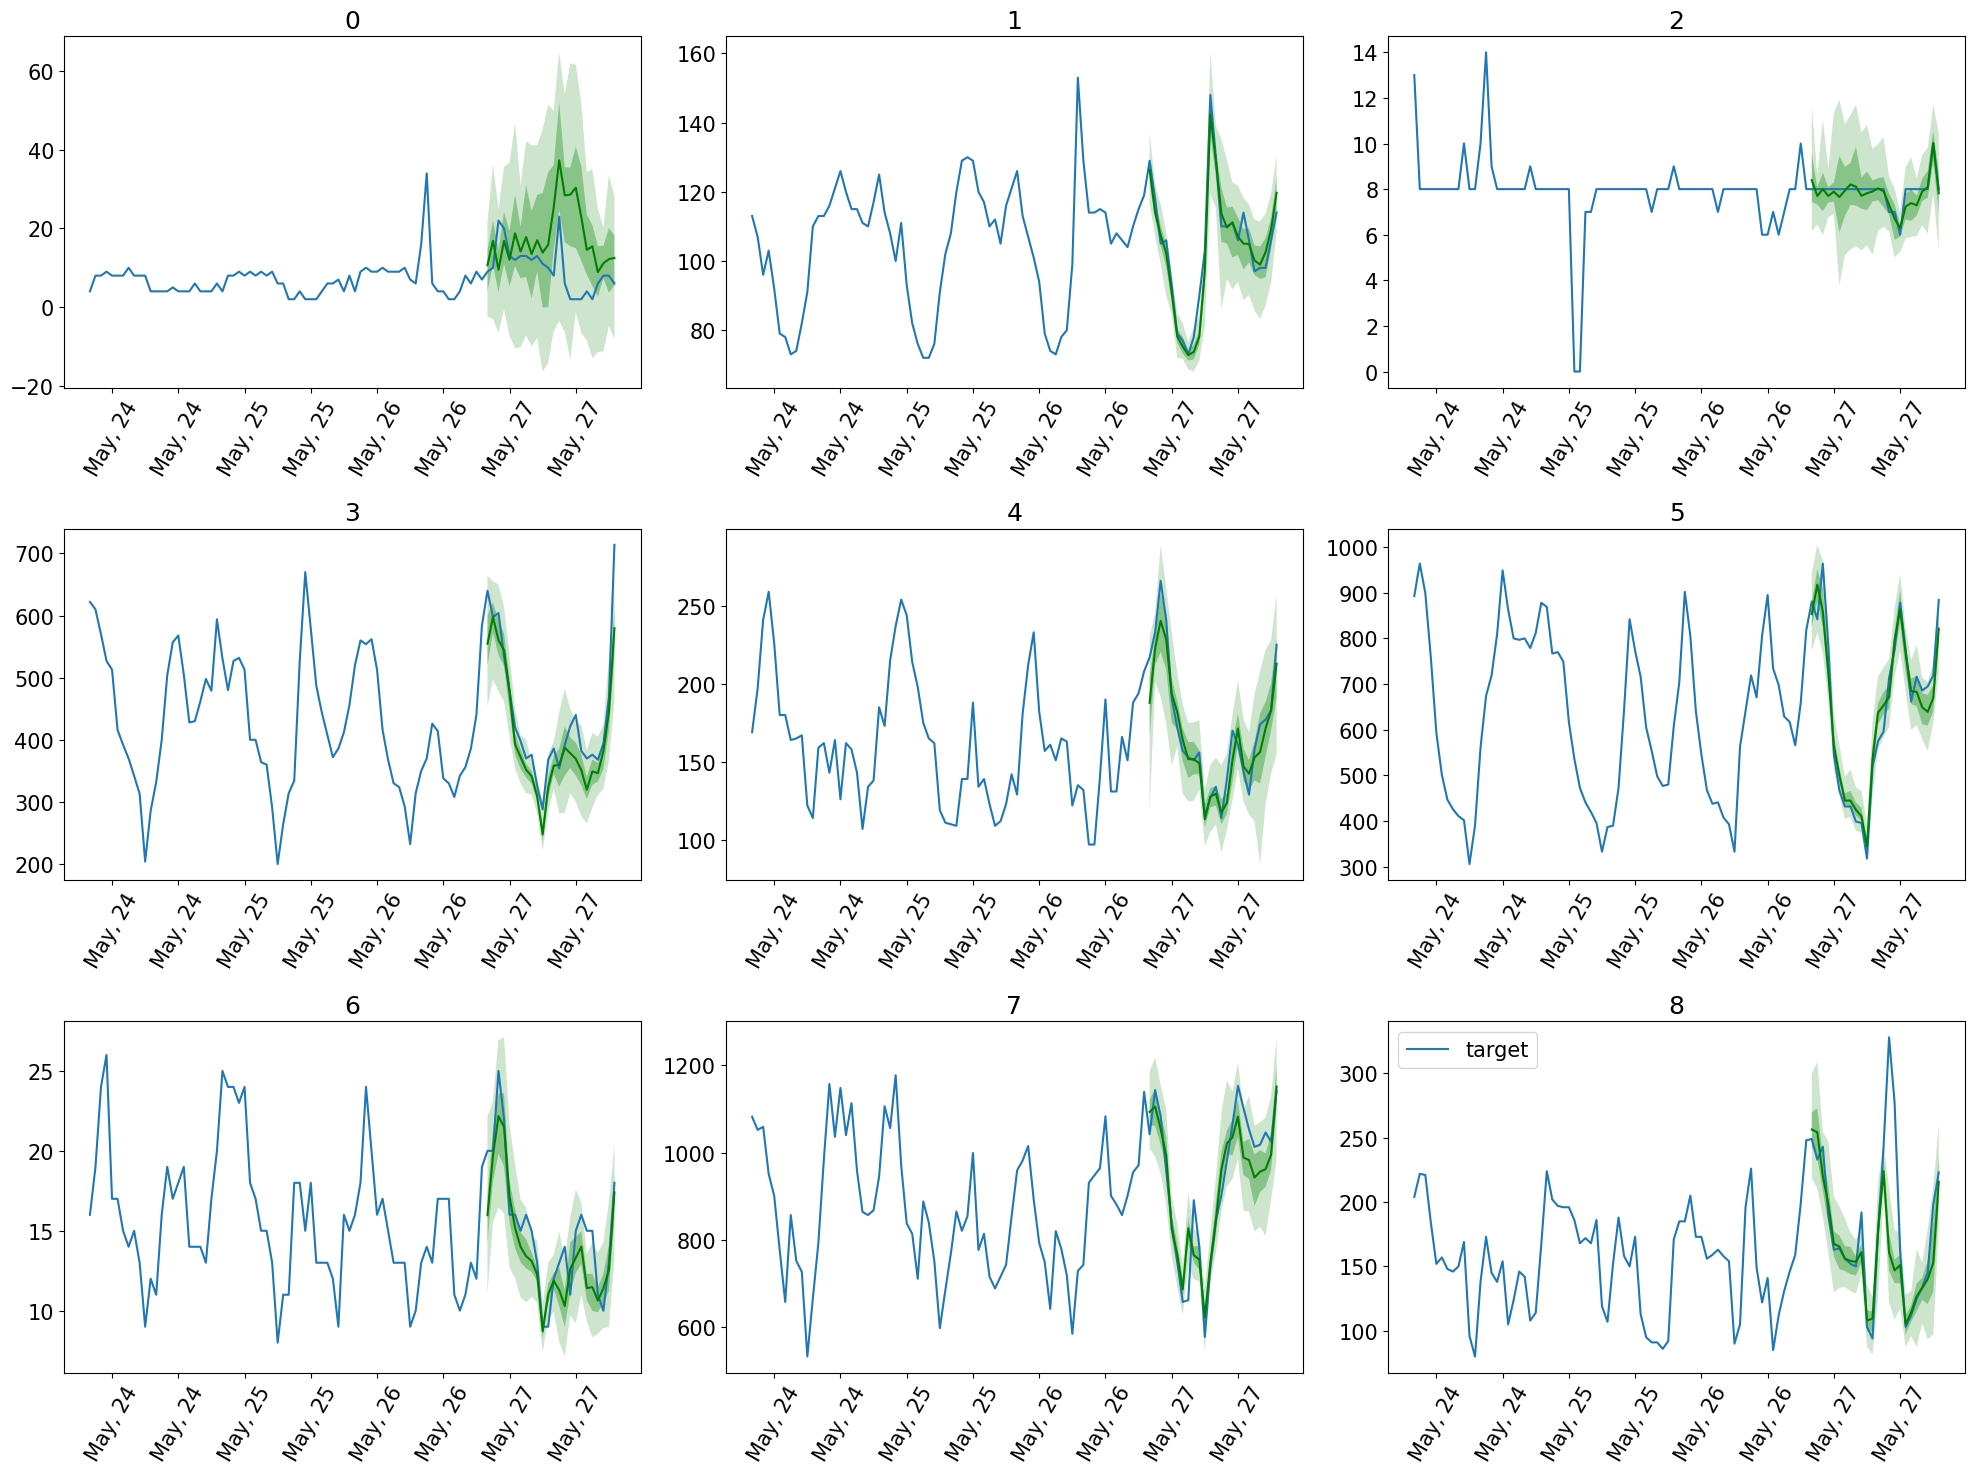

In [50]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [51]:
crpss = []
for i in range(20):
    estimator = LagGPTEstimator(
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*(i+1),
        max_context_length=dataset.metadata.prediction_length*20 + dataset.metadata.prediction_length,

        scaling="std",
        #rope_scaling=dict(type="linear", factor=2.0),
        # nhead=2,
        n_layer=1,
        # num_decoder_layers=2,
        # dim_feedforward=16,
        # activation="gelu",
        
        batch_size=32,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(accelerator="gpu", precision="bf16-mixed", max_epochs=0),
        ckpt_path='/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_220/checkpoints/epoch=29-step=3000.ckpt',
    )

    predictor = estimator.train(
            training_data=dataset.train,
            shuffle_buffer_length=1024,
            cache_data=True,
    )

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset.test,
        predictor=predictor,
    )

    forecasts = list(forecast_it)

    agg_metrics, _ = evaluator(iter(tss), iter(forecasts))

    
    crpss.append(agg_metrics["mean_wQuantileLoss"])
    print(agg_metrics["mean_wQuantileLoss"])

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | LagGPTModel | 31.7 K
--------------------------------------
31.7 K    Trainable params
0         Non-trainable params
31.7 K    Total params
0.127     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=0` reached.

Running evaluation: 2247it [00:00, 28771.61it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, met

0.04849598167856033


`Trainer.fit` stopped: `max_epochs=0` reached.

Running evaluation: 2247it [00:00, 30464.24it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) /

0.04573761988358172


`Trainer.fit` stopped: `max_epochs=0` reached.

Running evaluation: 2247it [00:00, 29657.72it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) /

0.04703984581618915


`Trainer.fit` stopped: `max_epochs=0` reached.

Running evaluation: 2247it [00:00, 28500.93it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) /

0.04688571621734713



Running evaluation: 2247it [00:00, 30959.00it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eva

0.04807501801546396


`Trainer.fit` stopped: `max_epochs=0` reached.

Running evaluation: 2247it [00:00, 29481.64it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) /

0.048674738541361035



Running evaluation: 2247it [00:00, 29736.32it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eva

0.04795658794825792


`Trainer.fit` stopped: `max_epochs=0` reached.

Running evaluation: 2247it [00:00, 35446.16it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) /

0.04870777947929808



Running evaluation: 2247it [00:00, 29072.30it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eva

0.04879662721388812



Running evaluation: 2247it [00:00, 29654.36it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eva

0.04872658249028868


`Trainer.fit` stopped: `max_epochs=0` reached.

Running evaluation: 2247it [00:00, 27972.15it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) /

0.049330644166766274


`Trainer.fit` stopped: `max_epochs=0` reached.

Running evaluation: 2247it [00:00, 30138.86it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
Process SpawnPoolWorker-906:
Process SpawnPoolWorker-908:
Process SpawnPoolWorker-911:
Process SpawnPoolWorker-902:
Process SpawnPoolWorker-912:
Process SpawnPoolWorker-905:
Process SpawnPoolWorker-907:
Process SpawnPoolWorker-898:
Process SpawnPoolWorker-904:
Process SpawnPoolWorker-903:
Process SpawnPoolWorker-897:
Process SpawnPoolWorker-900:
Process SpawnPoolWorker-901:
Process SpawnPoolWorker-910:
Process SpawnPoolWorker-899:
Process SpawnPoolWorker-909:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File

KeyboardInterrupt: 

Text(0, 0.5, 'CRPS')

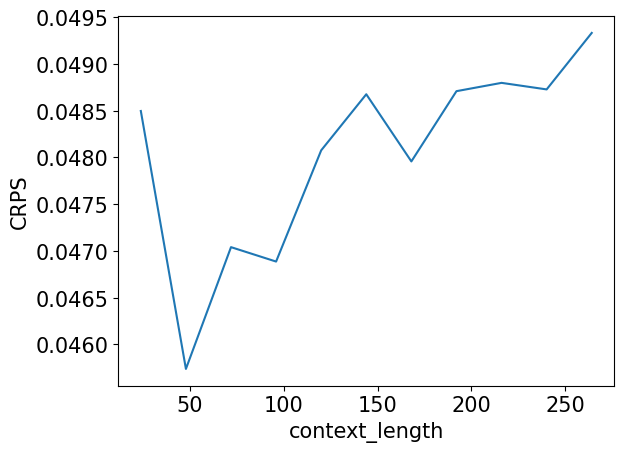

In [52]:
plt.plot([(i+1)*dataset.metadata.prediction_length for i in range(len(crpss))], crpss)
plt.xlabel("context_length")
plt.ylabel("CRPS")

In [ ]:
rope_crpss = []
for i in range(20):
    estimator = LagGPTEstimator(
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*(i+1),
        max_context_length=dataset.metadata.prediction_length*2 + dataset.metadata.prediction_length,

        scaling="std",
        rope_scaling=dict(type="linear", factor=i+1.1),
        # nhead=2,
        n_layer=1,
        # num_decoder_layers=2,
        # dim_feedforward=16,
        # activation="gelu",
        
        batch_size=64,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(accelerator="gpu", precision="bf16-mixed", max_epochs=0),
        ckpt_path='/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_324/checkpoints/epoch=27-step=2800.ckpt',
    )

    predictor = estimator.train(
            training_data=dataset.train,
            shuffle_buffer_length=1024,
            cache_data=True,
    )

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset.test,
        predictor=predictor,
    )

    forecasts = list(forecast_it)

    agg_metrics, _ = evaluator(iter(tss), iter(forecasts))

    
    rope_crpss.append(agg_metrics["mean_wQuantileLoss"])
    print(agg_metrics["mean_wQuantileLoss"])

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | LagGPTModel | 31.7 K
--------------------------------------
31.7 K    Trainable params
0         Non-trainable params
31.7 K    Total params
0.127     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=0` reached.
Running evaluation: 2247it [00:00, 31254.90it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR

0.04390381461939138


Running evaluation: 2247it [00:00, 29469.93it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eval

0.044064247496849354


`Trainer.fit` stopped: `max_epochs=0` reached.
Running evaluation: 2247it [00:00, 30849.46it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / 

0.044339620579530274


Running evaluation: 2247it [00:00, 34651.43it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eval

0.04372729754857237


`Trainer.fit` stopped: `max_epochs=0` reached.
Running evaluation: 2247it [00:00, 30294.05it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / 

0.04362661187602387


Running evaluation: 2247it [00:00, 30632.77it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eval

0.04383689017855792


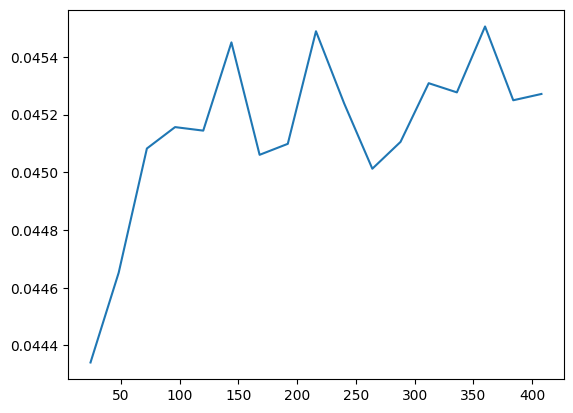

In [23]:
plt.plot([(i+1)*dataset.metadata.prediction_length for i in range(len(rope_crpss))], rope_crpss, label="linear")


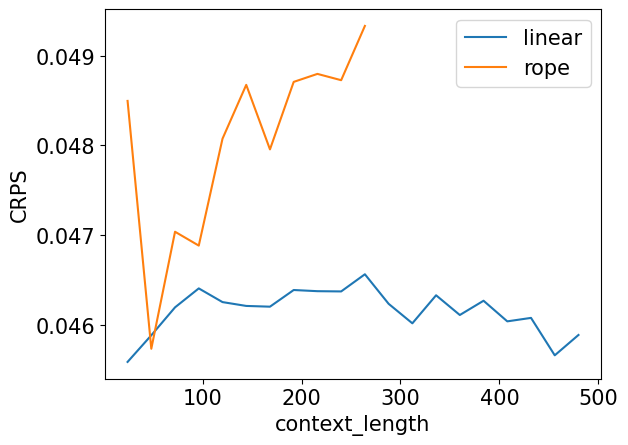

In [68]:
plt.plot([(i+1)*dataset.metadata.prediction_length for i in range(len(rope_crpss))], rope_crpss, label="linear")
plt.plot([(i+1)*dataset.metadata.prediction_length for i in range(len(crpss))], crpss, label="rope")
plt.xlabel("context_length")
plt.ylabel("CRPS")
plt.legend()

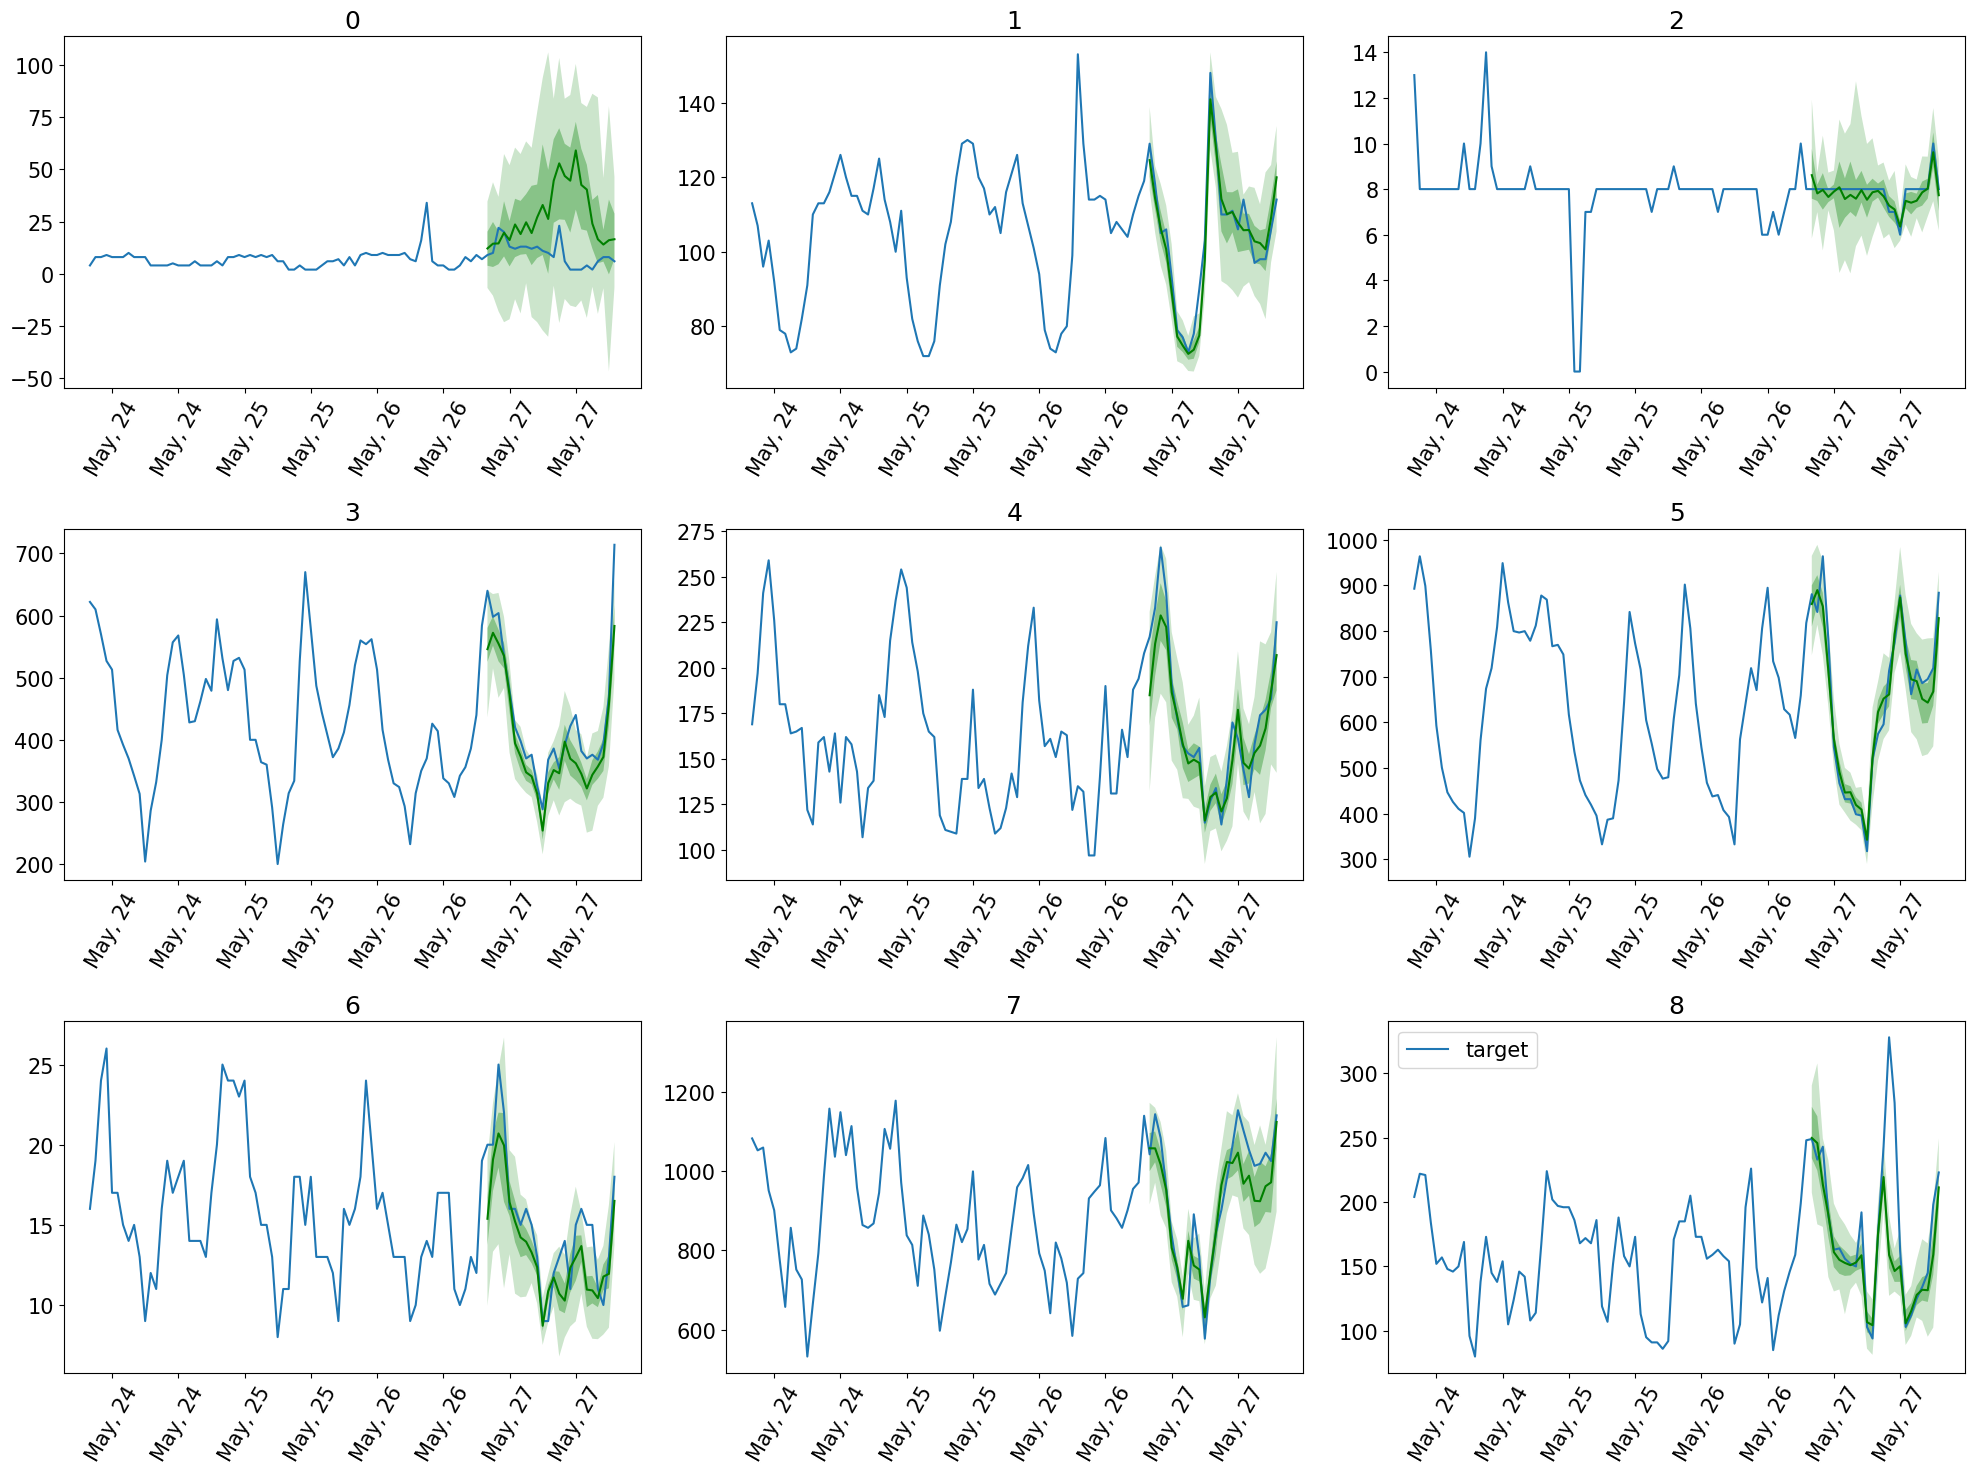

In [55]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [22]:
rope_dyn_crpss = []
for i in range(20):
    estimator = LagGPTEstimator(
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*(i+1),
        max_context_length=dataset.metadata.prediction_length + dataset.metadata.prediction_length,

        scaling="std",
        rope_scaling=dict(type="dynamic", factor=10.0),
        # nhead=2,
        n_layer=1,
        # num_decoder_layers=2,
        # dim_feedforward=16,
        # activation="gelu",
        
        batch_size=64,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(accelerator="gpu", precision="bf16-mixed", max_epochs=0),
        ckpt_path='/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_324/checkpoints/epoch=27-step=2800.ckpt' ,
    )

    predictor = estimator.train(
            training_data=dataset.train,
            shuffle_buffer_length=1024,
            cache_data=True,
    )

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset.test,
        predictor=predictor,
    )

    forecasts = list(forecast_it)

    agg_metrics, _ = evaluator(iter(tss), iter(forecasts))

    
    rope_dyn_crpss.append(agg_metrics["mean_wQuantileLoss"])
    print(agg_metrics["mean_wQuantileLoss"])

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | LagGPTModel | 31.7 K
--------------------------------------
31.7 K    Trainable params
0         Non-trainable params
31.7 K    Total params
0.127     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=0` reached.
Running evaluation: 2247it [00:00, 31256.76it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR

0.043847684819444795


`Trainer.fit` stopped: `max_epochs=0` reached.
Running evaluation: 2247it [00:00, 30817.58it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / 

0.04500362758100951


Running evaluation: 2247it [00:00, 29587.70it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eval

0.05305644541317151


Running evaluation: 2247it [00:00, 34096.70it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eval

0.05353294827588909


Running evaluation: 2247it [00:00, 30526.80it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eval

0.054918836387009014


Running evaluation: 2247it [00:00, 29994.88it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eval

0.05551990559788328


Running evaluation: 2247it [00:00, 30065.50it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eval

0.05550930288554233


`Trainer.fit` stopped: `max_epochs=0` reached.
Running evaluation: 2247it [00:00, 36761.57it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / 

0.06233311244498861


Running evaluation: 2247it [00:00, 34280.88it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eval

0.062101952217153804


Running evaluation: 2247it [00:00, 30887.07it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eval

0.06192297079962442


`Trainer.fit` stopped: `max_epochs=0` reached.


KeyboardInterrupt: 

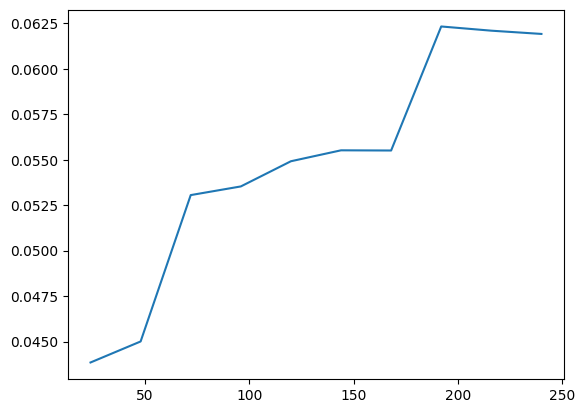

In [23]:
plt.plot([(i+1)*dataset.metadata.prediction_length for i in range(len(rope_dyn_crpss))], rope_dyn_crpss, label="dynamic")


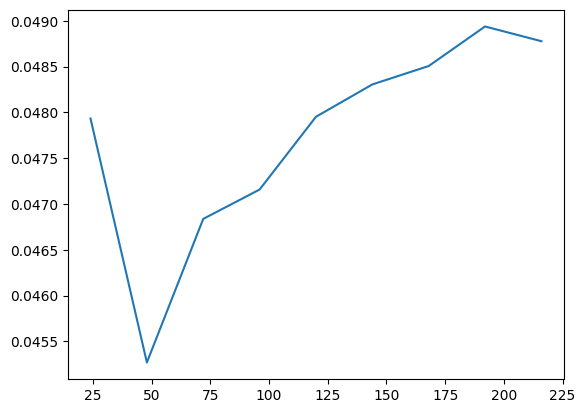

In [10]:
plt.plot([(i+1)*dataset.metadata.prediction_length for i in range(len(rope_dyn_crpss))], rope_dyn_crpss, label="dynamic")


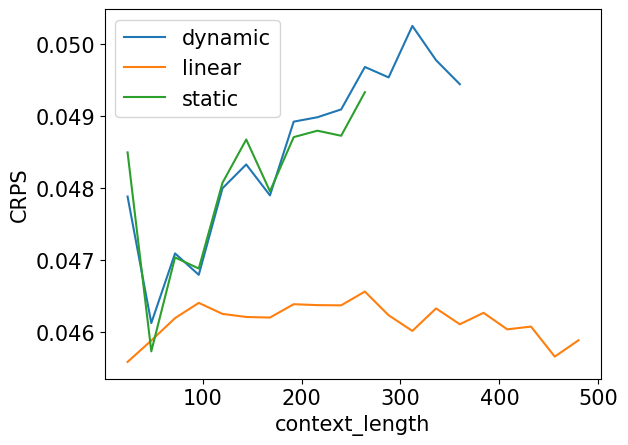

In [69]:
plt.plot([(i+1)*dataset.metadata.prediction_length for i in range(len(rope_dyn_crpss))], rope_dyn_crpss, label="dynamic")
plt.plot([(i+1)*dataset.metadata.prediction_length for i in range(len(rope_crpss))], rope_crpss, label="linear")
plt.plot([(i+1)*dataset.metadata.prediction_length for i in range(len(crpss))], crpss, label="static")
plt.xlabel("context_length")
plt.ylabel("CRPS")
plt.legend()

In [58]:
estimator = LagGPTEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    max_context_length=dataset.metadata.prediction_length*20 + dataset.metadata.prediction_length,
    
    scaling="std",
    rope_scaling=dict(type="NoPe", factor=2.0),
    # nhead=2,
    n_layer=1,
    # num_decoder_layers=2,
    # dim_feedforward=16,
    # activation="gelu",
    
    batch_size=256,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(accelerator="gpu", precision="bf16-mixed", max_epochs=30),
    
)

In [59]:
predictor = estimator.train(
        training_data=dataset.train,
        shuffle_buffer_length=1024,
        cache_data=True,
    )

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | LagGPTModel | 31.7 K
--------------------------------------
31.7 K    Trainable params
0         Non-trainable params
31.7 K    Total params
0.127     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 5.68239 (best 5.68239), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_253/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 5.40669 (best 5.40669), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_253/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 5.33598 (best 5.33598), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_253/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached 5.28980 (best 5.28980), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_253/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' was not in top 1
Epoch 5, global step 600: 'train_loss' reached 5.25999 (best 5.25999), saving model to '/mnt/scratch/kas

In [60]:
nope_crpss = []
for i in range(20):
    estimator = LagGPTEstimator(
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*(i+1),
        max_context_length=dataset.metadata.prediction_length*20 + dataset.metadata.prediction_length,

        scaling="std",
        rope_scaling=dict(type="NoPe", factor=2.0),
        # nhead=2,
        n_layer=1,
        # num_decoder_layers=2,
        # dim_feedforward=16,
        # activation="gelu",
        
        batch_size=32,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(accelerator="gpu", precision="bf16-mixed", max_epochs=0),
        ckpt_path='/mnt/scratch/kashif/pytorch-transformer-ts/lag-gpt/lightning_logs/version_253/checkpoints/epoch=29-step=3000.ckpt',
    )

    predictor = estimator.train(
            training_data=dataset.train,
            shuffle_buffer_length=1024,
            cache_data=True,
    )

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset.test,
        predictor=predictor,
    )

    forecasts = list(forecast_it)

    agg_metrics, _ = evaluator(iter(tss), iter(forecasts))

    
    nope_crpss.append(agg_metrics["mean_wQuantileLoss"])
    print(agg_metrics["mean_wQuantileLoss"])

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | LagGPTModel | 31.7 K
--------------------------------------
31.7 K    Trainable params
0         Non-trainable params
31.7 K    Total params
0.127     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=0` reached.

Running evaluation: 2247it [00:00, 29174.45it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-P

0.045322826066755285


`Trainer.fit` stopped: `max_epochs=0` reached.

Running evaluation: 2247it [00:00, 28126.25it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) /

0.04627406872745918


`Trainer.fit` stopped: `max_epochs=0` reached.

Running evaluation: 2247it [00:00, 28039.23it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) /

0.046628359134528126


`Trainer.fit` stopped: `max_epochs=0` reached.

Running evaluation: 2247it [00:00, 30025.84it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) /

0.04726309300138066



Running evaluation: 2247it [00:00, 31698.94it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eva

0.047792639055270224



Running evaluation: 2247it [00:00, 26109.68it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eva

0.04833272976586679


`Trainer.fit` stopped: `max_epochs=0` reached.

Running evaluation: 2247it [00:00, 28832.26it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) /

0.04923710794443915



Running evaluation: 2247it [00:00, 38501.86it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eva

0.04909611349778633



Running evaluation: 2247it [00:00, 28280.87it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eva

0.04896911245953315


KeyboardInterrupt: 

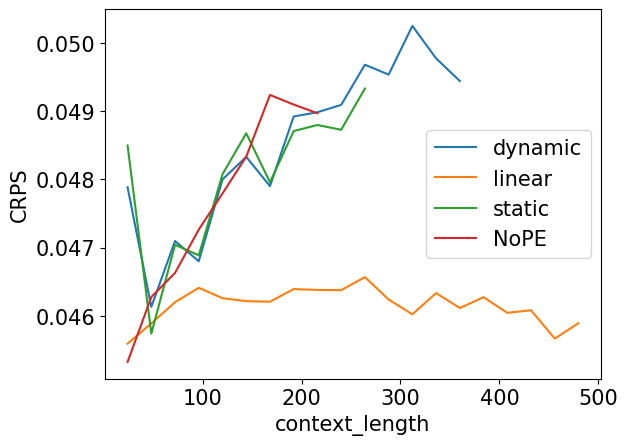

In [70]:
plt.plot([(i+1)*dataset.metadata.prediction_length for i in range(len(rope_dyn_crpss))], rope_dyn_crpss, label="dynamic")
plt.plot([(i+1)*dataset.metadata.prediction_length for i in range(len(rope_crpss))], rope_crpss, label="linear")
plt.plot([(i+1)*dataset.metadata.prediction_length for i in range(len(crpss))], crpss, label="static")
plt.plot([(i+1)*dataset.metadata.prediction_length for i in range(len(nope_crpss))], nope_crpss, label="NoPE")
plt.xlabel("context_length")
plt.ylabel("CRPS")
plt.legend()